In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import tensorflow as tf
from tensorflow.keras import backend as keras_backend
import numpy as np

gpu_on = True

if gpu_on :
    gpu_devices = tf.config.experimental.list_physical_devices("GPU")
    for device in gpu_devices:
        tf.config.experimental.set_memory_growth(device, True)
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    gpu_devices = tf.config.experimental.list_physical_devices("CPU")

print(gpu_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from src.data_loader.cycle_gan import CycleGanDataloader
from tensorflow.keras.applications.inception_v3 import preprocess_input
from glob import glob

task = "cycle_gan"
data_set_name = "HE_IHC_dataset"
batch_size = 2
on_memory = False
augumentation_proba = 0.8
target_size = (512,512)
interpolation = "bilinear"
class_mode = "binary"
# class_mode = "categorical"
dtype="float32"

train_image_path_list = glob(f"./datasets/{task}/{data_set_name}/HE/train/*/*")
train_target_image_path_list = glob(f"./datasets/{task}/{data_set_name}/IHC/train/*/*") 
test_image_path_list = glob(f"./datasets/{task}/{data_set_name}/HE/test/*/*")
test_target_image_path_list = glob(f"./datasets/{task}/{data_set_name}/IHC/test/*/*")

train_data_loader = CycleGanDataloader(image_path_list=train_image_path_list,
                                       target_image_path_list=train_target_image_path_list,
                                       batch_size=batch_size,
                                       on_memory=on_memory,
                                       augumentation_proba=augumentation_proba,
                                       preprocess_input=preprocess_input,
                                       target_size=target_size,
                                       interpolation=interpolation,
                                       shuffle=True,
                                       dtype=dtype
)
test_data_loader = CycleGanDataloader(image_path_list=test_image_path_list,
                                      target_image_path_list=test_target_image_path_list,
                                       batch_size=1,
                                       on_memory=False,
                                       augumentation_proba=0,
                                       preprocess_input=preprocess_input,
                                       target_size=target_size,
                                       interpolation=interpolation,                                       
                                       shuffle=False,
                                       dtype=dtype
)

Source data num 11000, Target data num: 11000
Source data num 3000, Target data num: 3000


In [3]:
def change_loss_fun_name(loss_function, name):
    new_loss_function = deepcopy(loss_function)

    new_loss_function.__name__ = name
    return new_loss_function

In [4]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.metrics import Accuracy
from tensorflow.image import ssim
from src.model.build_model import build_generator, build_discriminator
from src.util.custom_loss import dice_score
from src.util.loss_cycle_gan import get_channel_weighted_dice_loss
from src.model.cycle_gan import CycleGan

from copy import deepcopy

optimizer = Nadam(1e-4, beta_1=0.5, clipnorm=1)
input_image_shape = (*target_size, 3)
output_image_shape = (*target_size, 3)

image_size = input_image_shape[0]
depth = 0
while image_size != 1:
    image_size //= 2
    depth += 1
depth -= 3
    
disc_patch = (input_image_shape[0] // (2 ** depth), input_image_shape[1] // (2 ** depth), 1)
valid_patch = np.ones((batch_size, *disc_patch), dtype=np.float32)
fake_patch = np.zeros((batch_size, *disc_patch), dtype=np.float32)

generator_G = build_generator(input_image_shape=input_image_shape,
                            output_channels=3,
                            depth = None,
                            generator_power=8,
                            activation="tanh"
)
generator_F = build_generator(input_image_shape=input_image_shape,
                                    output_channels=3,
                                    depth = None,
                                    generator_power=8,
                                    activation="tanh"
)

discriminator_X = build_discriminator(input_image_shape=input_image_shape,
                                    output_image_shape=None,
                                    depth = None,
                                    discriminator_power=8
)
discriminator_Y = build_discriminator(input_image_shape=input_image_shape,
                                    output_image_shape=None,
                                    depth = None,
                                    discriminator_power=8
)

cycle_gan_model = CycleGan(
    generator_G=generator_G, 
    generator_F=generator_F, 
    discriminator_X=discriminator_X, 
    discriminator_Y=discriminator_Y
)

cycle_gan_model.compile(
    gen_G_optimizer=optimizer,
    gen_F_optimizer=optimizer,
    disc_X_optimizer=optimizer,
    disc_Y_optimizer=optimizer,
    image_loss=get_channel_weighted_dice_loss
)


Segmentation Models: using `keras` framework.


In [5]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint

class GANMonitor(Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, num_img=4):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        _, ax = plt.subplots(4, 2, figsize=(12, 12))
        for i, img in enumerate(test_horses.take(self.num_img)):
            prediction = self.model.gen_G(img)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

            ax[i, 0].imshow(img)
            ax[i, 1].imshow(prediction)
            ax[i, 0].set_title("Input image")
            ax[i, 1].set_title("Translated image")
            ax[i, 0].axis("off")
            ax[i, 1].axis("off")

            prediction = keras.preprocessing.image.array_to_img(prediction)
            prediction.save(
                "generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch + 1)
            )
        plt.show()
        plt.close()

In [6]:
plotter = GANMonitor()
checkpoint_filepath = "./cyclegan_checkpoints.{epoch:03d}"
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath
)

In [7]:
cycle_gan_model.fit(
    train_data_loader,
    epochs=20,
    callbacks=[plotter, model_checkpoint_callback],
)

Epoch 1/20
   95/11000 [..............................] - ETA: 5:33:04 - G_loss: nan - F_loss: nan - D_X_loss: 0.4985 - D_Y_loss: 0.4997

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\gr300\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-1ebe62d95bdc>", line 1, in <module>
    cycle_gan_model.fit(
  File "C:\Users\gr300\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py", line 1183, in fit
    tmp_logs = self.train_function(iterator)
  File "C:\Users\gr300\anaconda3\lib\site-packages\tensorflow\python\eager\def_function.py", line 889, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\gr300\anaconda3\lib\site-packages\tensorflow\python\eager\def_function.py", line 917, in _call
    return self._stateless_fn(*args, **kwds)  # pylint: disable=not-callable
  File "C:\Users\gr300\anaconda3\lib\site-packages\tensorflow\python\eager\function.py", line 3023, in __call__
    return graph_function._call_flat(
  File "C:\Users\gr300\anaconda3\lib\site-packages\tensorflow\py

TypeError: object of type 'NoneType' has no len()

# Unused Code

In [10]:
image_array, target_image_array = train_data_loader[0]

In [11]:
converted = generator_G(image_array)[0]
converted = np.array(converted)
converted = (converted + 1) * 127.5
converted = converted.astype("uint8")

In [12]:
from matplotlib import pyplot as plt

In [13]:
temp_array = image_array[0]
temp_array = (temp_array + 1) * 127.5
temp_array = temp_array.astype("uint8")

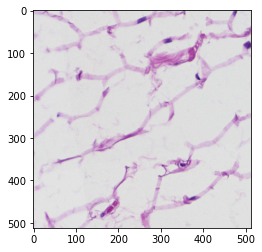

In [14]:
plt.imshow(temp_array)

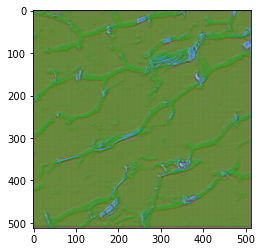

In [15]:
plt.imshow(converted)

In [ ]:
def train_step(batch_data):
    # x is Horse and y is zebra
    real_x, real_y = batch_data

    # For CycleGAN, we need to calculate different
    # kinds of losses for the generators and discriminators.
    # We will perform the following steps here:
    #
    # 1. Pass real images through the generators and get the generated images
    # 2. Pass the generated images back to the generators to check if we
    #    we can predict the original image from the generated image.
    # 3. Do an identity mapping of the real images using the generators.
    # 4. Pass the generated images in 1) to the corresponding discriminators.
    # 5. Calculate the generators total loss (adverserial + cycle + identity)
    # 6. Calculate the discriminators loss
    # 7. Update the weights of the generators
    # 8. Update the weights of the discriminators
    # 9. Return the losses in a dictionary

    with tf.GradientTape(persistent=True) as tape:
        # Horse to fake zebra
        fake_y = self.gen_G(real_x, training=True)
        # Zebra to fake horse -> y2x
        fake_x = self.gen_F(real_y, training=True)

        # Cycle (Horse to fake zebra to fake horse): x -> y -> x
        cycled_x = self.gen_F(fake_y, training=True)
        # Cycle (Zebra to fake horse to fake zebra) y -> x -> y
        cycled_y = self.gen_G(fake_x, training=True)

        # Identity mapping
        same_x = self.gen_F(real_x, training=True)
        same_y = self.gen_G(real_y, training=True)

        # Discriminator output
        disc_real_x = self.disc_X(real_x, training=True)
        disc_fake_x = self.disc_X(fake_x, training=True)

        disc_real_y = self.disc_Y(real_y, training=True)
        disc_fake_y = self.disc_Y(fake_y, training=True)

        # Generator adverserial loss
        gen_G_loss = self.generator_loss_fn(disc_fake_y)
        gen_F_loss = self.generator_loss_fn(disc_fake_x)

        # Generator cycle loss
        cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
        cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

        # Generator identity loss
        id_loss_G = (
            self.identity_loss_fn(real_y, same_y)
            * self.lambda_cycle
            * self.lambda_identity
        )
        id_loss_F = (
            self.identity_loss_fn(real_x, same_x)
            * self.lambda_cycle
            * self.lambda_identity
        )

        # Total generator loss
        total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
        total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

        # Discriminator loss
        disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
        disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

    # Get the gradients for the generators
    grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
    grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

    # Get the gradients for the discriminators
    disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
    disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

    # Update the weights of the generators
    self.gen_G_optimizer.apply_gradients(
        zip(grads_G, self.gen_G.trainable_variables)
    )
    self.gen_F_optimizer.apply_gradients(
        zip(grads_F, self.gen_F.trainable_variables)
    )

    # Update the weights of the discriminators
    self.disc_X_optimizer.apply_gradients(
        zip(disc_X_grads, self.disc_X.trainable_variables)
    )
    self.disc_Y_optimizer.apply_gradients(
        zip(disc_Y_grads, self.disc_Y.trainable_variables)
    )

    return {
        "G_loss": total_loss_G,
        "F_loss": total_loss_F,
        "D_X_loss": disc_X_loss,
        "D_Y_loss": disc_Y_loss,
    }

# Unused Code

In [ ]:
y_true = train_data_loader[0][0]
y_true = tf.convert_to_tensor(y_true)
one_array = np.ones((1,512,512,3))
one_diff_array = deepcopy(one_array)
one_diff_array[:,:,:,0] = 0
one_diff_array[:,:30,:30,1] = 0

one_array = tf.convert_to_tensor(one_array)
one_diff_array = tf.convert_to_tensor(one_diff_array)

In [ ]:
beta = 0.7
CHANNEL_WEIGHTED_AXIS = [1, 2]
y_true = one_array
y_pred = one_diff_array
smooth = K.epsilon()

alpha = 1 - beta
prevalence_per_channel = \
    K.mean((y_true + 1) / 2, axis=CHANNEL_WEIGHTED_AXIS)

tp = K.sum(y_true * y_pred, axis=CHANNEL_WEIGHTED_AXIS)
tn = K.sum((1 - y_true) * (1 - y_pred), axis=CHANNEL_WEIGHTED_AXIS)
fp = K.sum(y_pred, axis=CHANNEL_WEIGHTED_AXIS) - tp
fn = K.sum(y_true, axis=CHANNEL_WEIGHTED_AXIS) - tp

channel_weighted_dice_loss = \
    (tp + smooth) / (tp + alpha * fn + beta * fp + smooth) * \
    (smooth + prevalence_per_channel)

print(f"channel_weighted_dice: {channel_weighted_dice_loss}")
print(f"channel_weighted_dice_loss: {channel_weighted_dice_loss.shape}")

channel_weighted_dice_loss = K.mean(channel_weighted_dice_loss)

print(f"prevalence_per_channel_shape: {prevalence_per_channel.shape}")
print(f"true_positive_shape: {tp.shape}")
print(f"false_positive_shape: {tp.shape}")
print(f"false_negative_shape: {tn.shape}")
print(f"channel_weighted_dice: {channel_weighted_dice_loss}")
